In [1]:
# Importing libraries

import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
#Transformers
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
#Dataloader

#Path for training and testing directory
train_path="../input/intel-image-classification/seg_train/seg_train"
test_path="../input/intel-image-classification/seg_test/seg_test"

batch_size=12

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=batch_size, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=batch_size, shuffle=True
)

In [6]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
print(classes,'\n\n Number of classes: '+ str(len(classes)))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] 

 Number of classes: 6


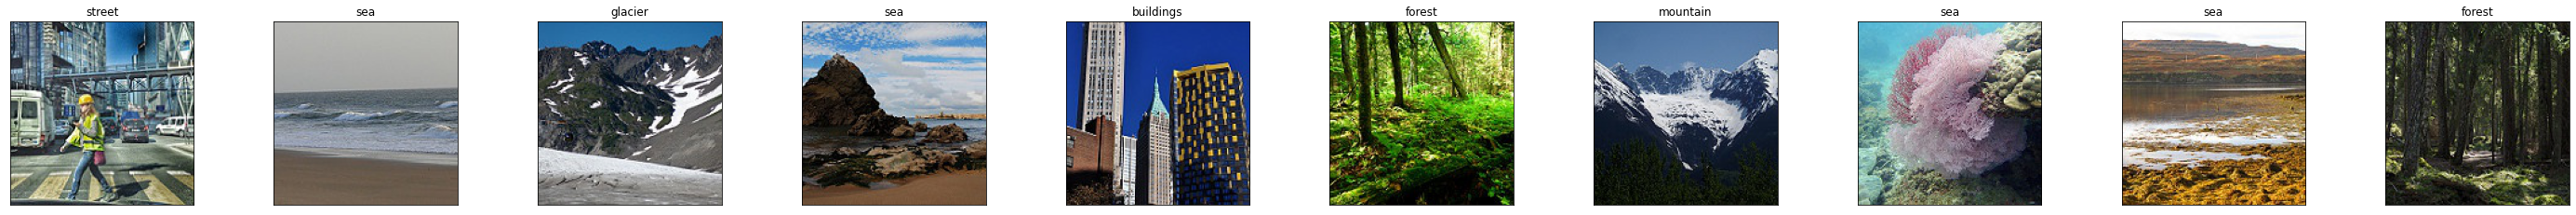

In [8]:
#Visualizing a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) # convert from Tensor image
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50,8))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [9]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
            
        


In [10]:
model=ConvNet(num_classes=6).to(device)
model

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=6, bias=True)
)

In [11]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [12]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [13]:
print(train_count,test_count)

14034 3000


In [14]:
# epoch number
num_epochs=19

In [15]:
#Model training and saving best model
# track test loss
test_loss=0.0

class_correct= list(0. for i in range(6))
class_total= list(0. for i in range(6))

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        loss=loss_function(outputs,labels)
        test_loss+= loss.cpu().data*images.size(0)
        #compare predictions to true label
        correct_tensor = prediction.eq(labels.data.view_as(prediction))
        correct = np.squeeze(correct_tensor.cpu().numpy())
    
        # calculate test accuracy
        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            

    test_loss=test_loss/test_count
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch+1)+' Train Loss: '+str(train_loss.item())+' Train Accuracy: '+str(np.round(train_accuracy*100, 4))+'%'+' Test Accuracy: '+str(np.round(test_accuracy*100, 4))+'%')
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'CNN_intel_image_classification.pth')
        best_accuracy=test_accuracy
    
       


Epoch: 1 Train Loss: 4.6172709465026855 Train Accuracy: 60.3819% Test Accuracy: 72.6%
Epoch: 2 Train Loss: 0.6484630107879639 Train Accuracy: 77.1626% Test Accuracy: 73.8667%
Epoch: 3 Train Loss: 0.5044721364974976 Train Accuracy: 82.8488% Test Accuracy: 75.5333%
Epoch: 4 Train Loss: 0.4318106770515442 Train Accuracy: 85.7631% Test Accuracy: 75.9667%
Epoch: 5 Train Loss: 0.36429715156555176 Train Accuracy: 88.2357% Test Accuracy: 74.9%
Epoch: 6 Train Loss: 0.32461169362068176 Train Accuracy: 89.3473% Test Accuracy: 76.2%
Epoch: 7 Train Loss: 0.28613144159317017 Train Accuracy: 90.7368% Test Accuracy: 74.2667%
Epoch: 8 Train Loss: 0.23802150785923004 Train Accuracy: 92.5538% Test Accuracy: 73.5667%
Epoch: 9 Train Loss: 0.21365898847579956 Train Accuracy: 93.5656% Test Accuracy: 76.0667%
Epoch: 10 Train Loss: 0.1930590271949768 Train Accuracy: 94.0359% Test Accuracy: 75.7%
Epoch: 11 Train Loss: 0.1561744660139084 Train Accuracy: 95.5537% Test Accuracy: 75.1333%
Epoch: 12 Train Loss: 0.14

In [16]:

#average test loss
# test_loss=test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2s/%2d)' % 
              (classes[i], 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        
         print('Test Accuracy of %5s: N/A (no training example)' % (classes[i]))

            
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct)/np.sum(class_total),np.sum(class_correct),np.sum(class_total)))

Test Loss: 1.212282

Test Accuracy of buildings: 68% (5688.0/8303)
Test Accuracy of forest: 93% (8437.0/9006)
Test Accuracy of glacier: 68% (7196.0/10507)
Test Accuracy of mountain: 74% (7433.0/9975)
Test Accuracy of   sea: 70% (6844.0/9690)
Test Accuracy of street: 75% (7158.0/9519)

Test Accuracy (Overall): 75% (42756/57000)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


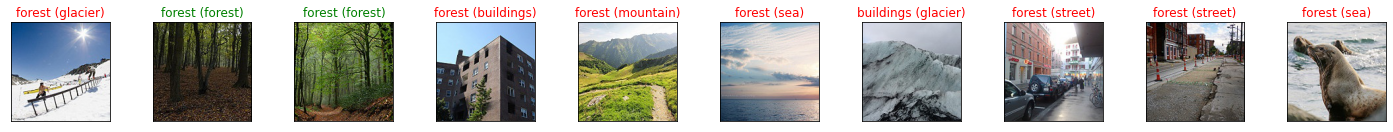

In [17]:
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[correct[idx]], classes[labels[idx]]),
                 color=("green" if correct[idx]==labels[idx].item() else "red"))
